In [12]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import pandas as pd
import seaborn as sns

from river import tree
from river import compose
from river import linear_model
from river import preprocessing
from sklearn.model_selection import train_test_split

from source.config import *
from source.stability.incremental_stability_analyzer import IncrementalStabilityAnalyzer
from source.utils.incremental_model_utils import train_incremental_model
from source.data_loaders.phishing_dataset_from_pd import PhishingDatasetFromPandas

In [14]:
sns.set(rc={'figure.figsize':(15, 5)})
dataset_name = 'phishing'
dataset_config = DATASETS_CONFIG[dataset_name]
TARGET_COLUMN = dataset_config['target_column']

In [15]:
# Creating a data frame
df = pd.read_csv("../../datasets/phishing.csv", delimiter=',')
df.head()

,empty_server_form_handler,popup_window,https,request_from_other_domain,anchor_from_other_domain,is_popular,long_url,age_of_domain,ip_in_url,is_phishing
0,0.0,0.0,0.0,0.0,0.0,0.5,1.0,1,1,1
1,1.0,0.0,0.5,0.5,0.0,0.5,0.0,1,0,1
2,0.0,0.0,1.0,0.0,0.5,0.5,0.0,1,0,1
3,0.0,0.0,1.0,0.0,0.0,1.0,0.5,0,0,1
4,1.0,0.0,0.5,1.0,0.0,0.5,0.5,1,0,0


In [16]:
df.shape

(1250, 10)

In [17]:
df.columns

Index(['empty_server_form_handler', 'popup_window', 'https',
       'request_from_other_domain', 'anchor_from_other_domain', 'is_popular',
       'long_url', 'age_of_domain', 'ip_in_url', 'is_phishing'],
      dtype='object')

In [18]:
df[TARGET_COLUMN].value_counts()

0    702
1    548
Name: is_phishing, dtype: int64

In [19]:
dataset_size = df.shape[0]
test_size = int(TEST_FRACTION * dataset_size)
validation_size = test_size

train_cv_df, test_df = train_test_split(df, test_size=test_size, random_state=SEED)
train_df, cv_df = train_test_split(train_cv_df, test_size=validation_size, random_state=SEED)
print("train_df shape: ", train_df.shape)
print("cv_df shape: ", cv_df.shape)
print("test_df shape: ", test_df.shape)

train_df shape:  (750, 10)
cv_df shape:  (250, 10)
test_df shape:  (250, 10)


In [20]:
train_dataset = PhishingDatasetFromPandas(pd_dataset=train_df)

### Analyze stability of Adaptive Random Forest classifier

In [21]:
def get_base_model():
    return compose.Pipeline(
            preprocessing.StandardScaler(),
            tree.HoeffdingTreeClassifier(grace_period=50, delta=0.01)
        ), 'HoeffdingTreeClassifier'

In [22]:
base_model, base_model_name = get_base_model()

# Conduct model training
base_model = train_incremental_model(base_model, train_dataset, dataset_size, print_every=200)

2022-11-17 13:32:24 incremental_model_utils.py INFO    : Iteration 200/1250 -- Accuracy: 76.88%; WeightedF1: 76.91%
2022-11-17 13:32:24 incremental_model_utils.py INFO    : Iteration 400/1250 -- Accuracy: 83.71%; WeightedF1: 83.71%
2022-11-17 13:32:24 incremental_model_utils.py INFO    : Iteration 600/1250 -- Accuracy: 86.64%; WeightedF1: 86.65%




Metrics after incremental model training:
Accuracy: 86.78%
WeightedF1: 86.79%


In [23]:
stability_analyzer = IncrementalStabilityAnalyzer(base_model,
                                                  base_model_name=base_model_name,
                                                  train_pd_dataset=cv_df,
                                                  test_pd_dataset=test_df,
                                                  test_y_true=test_df[TARGET_COLUMN],
                                                  dataset_reader=PhishingDatasetFromPandas,
                                                  dataset_name=dataset_name,
                                                  n_estimators=200)

2022-11-17 13:32:25 stability_analyzer.py INFO    : Start testing of classifier 1 / 200
2022-11-17 13:32:25 stability_analyzer.py INFO    : Classifier 1 / 200 was tested
2022-11-17 13:32:25 stability_analyzer.py INFO    : Start testing of classifier 2 / 200
2022-11-17 13:32:25 stability_analyzer.py INFO    : Classifier 2 / 200 was tested
2022-11-17 13:32:25 stability_analyzer.py INFO    : Start testing of classifier 3 / 200
2022-11-17 13:32:25 stability_analyzer.py INFO    : Classifier 3 / 200 was tested
2022-11-17 13:32:25 stability_analyzer.py INFO    : Start testing of classifier 4 / 200
2022-11-17 13:32:25 stability_analyzer.py INFO    : Classifier 4 / 200 was tested
2022-11-17 13:32:25 stability_analyzer.py INFO    : Start testing of classifier 5 / 200
2022-11-17 13:32:25 stability_analyzer.py INFO    : Classifier 5 / 200 was tested
2022-11-17 13:32:25 stability_analyzer.py INFO    : Start testing of classifier 6 / 200
2022-11-17 13:32:25 stability_analyzer.py INFO    : Classifier

General Ensemble Accuracy: 0.884
Mean: 0.3727
Std: 0.0083
IQR: 0.008
Per sample accuracy: 0.8819
Label stability: 0.9907
Jitter: 0.0061




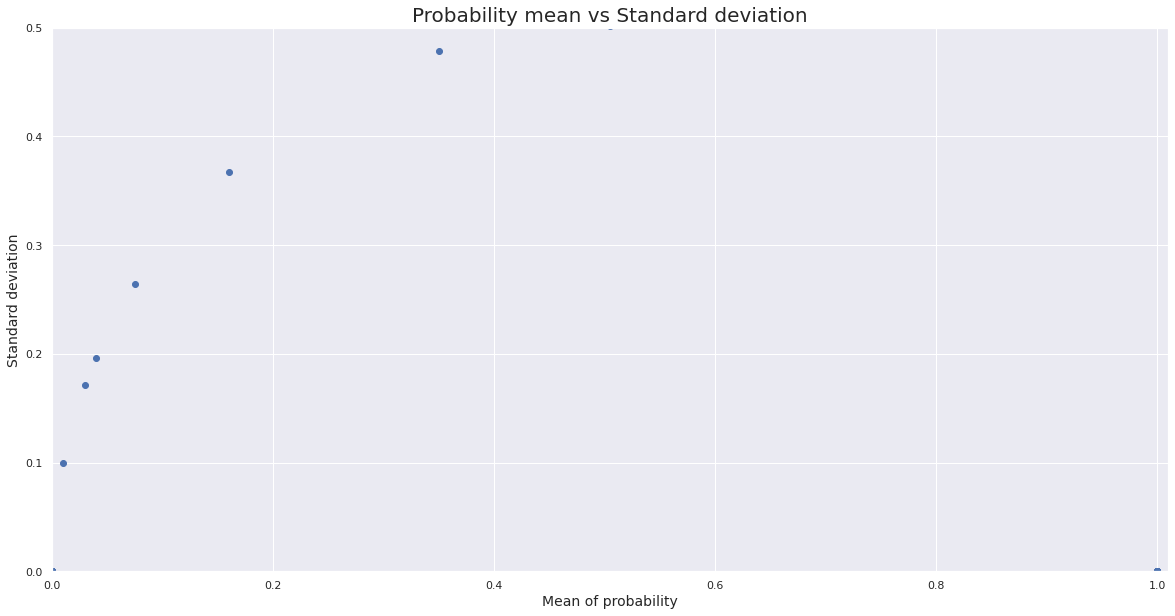

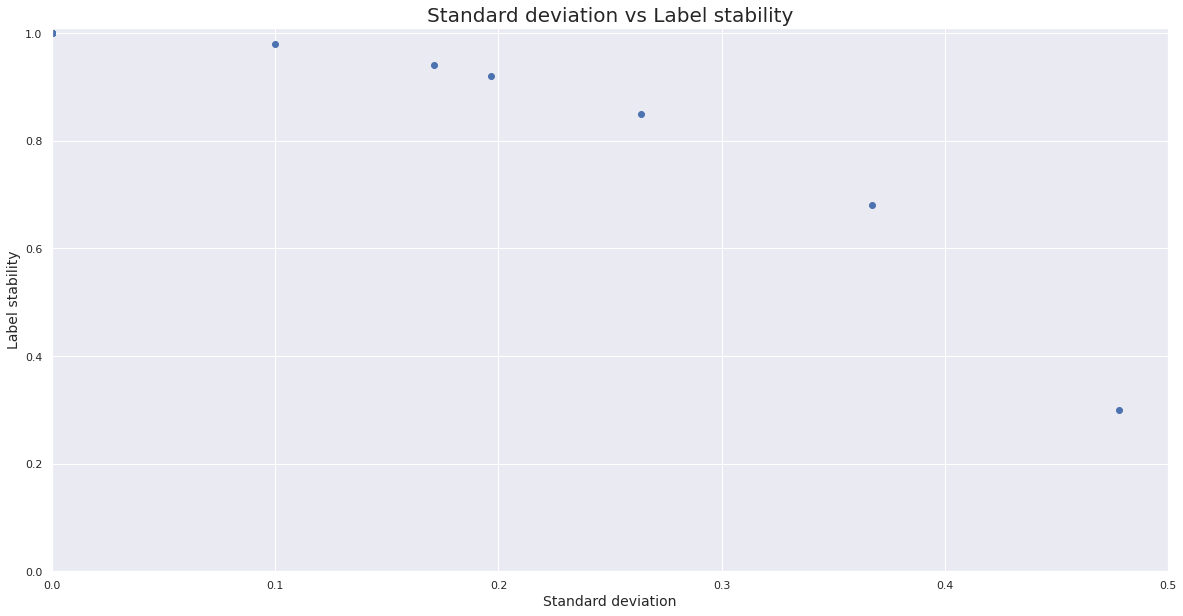

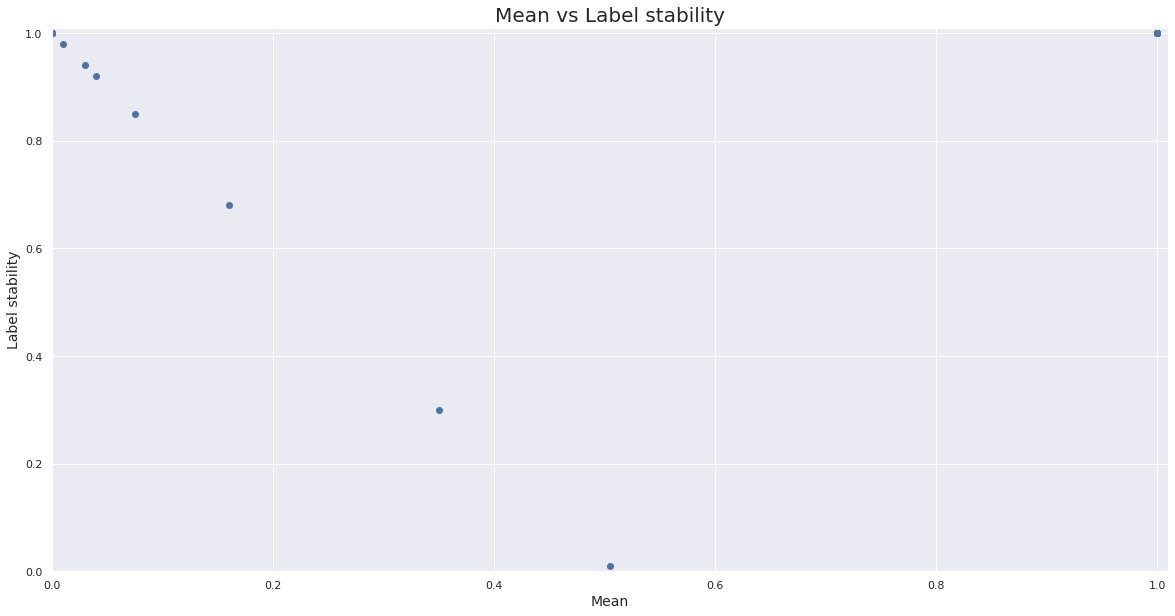

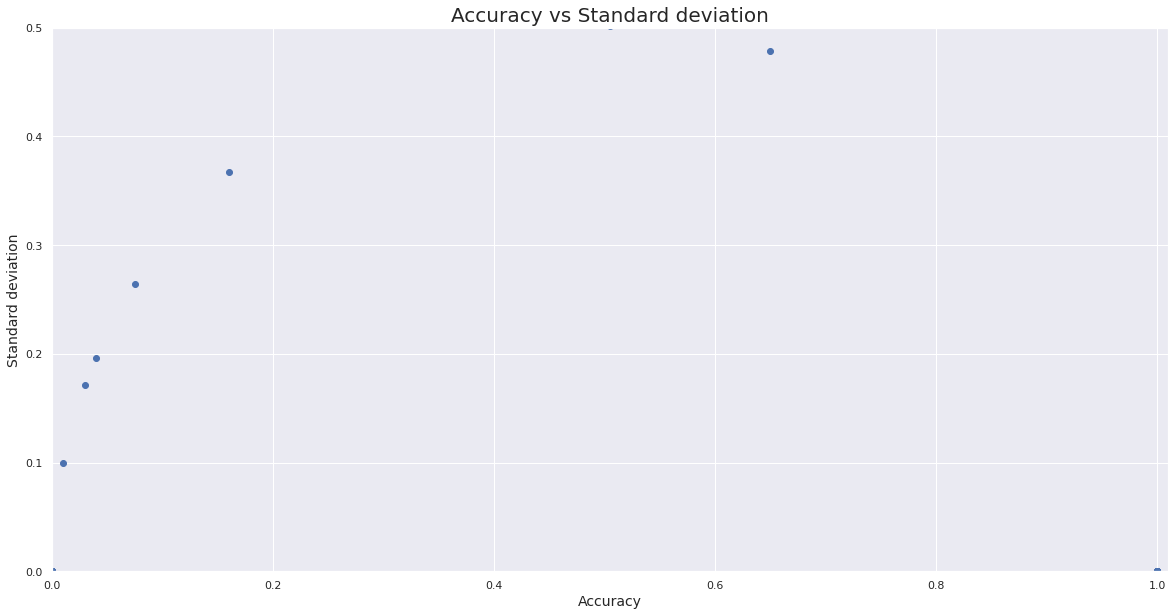

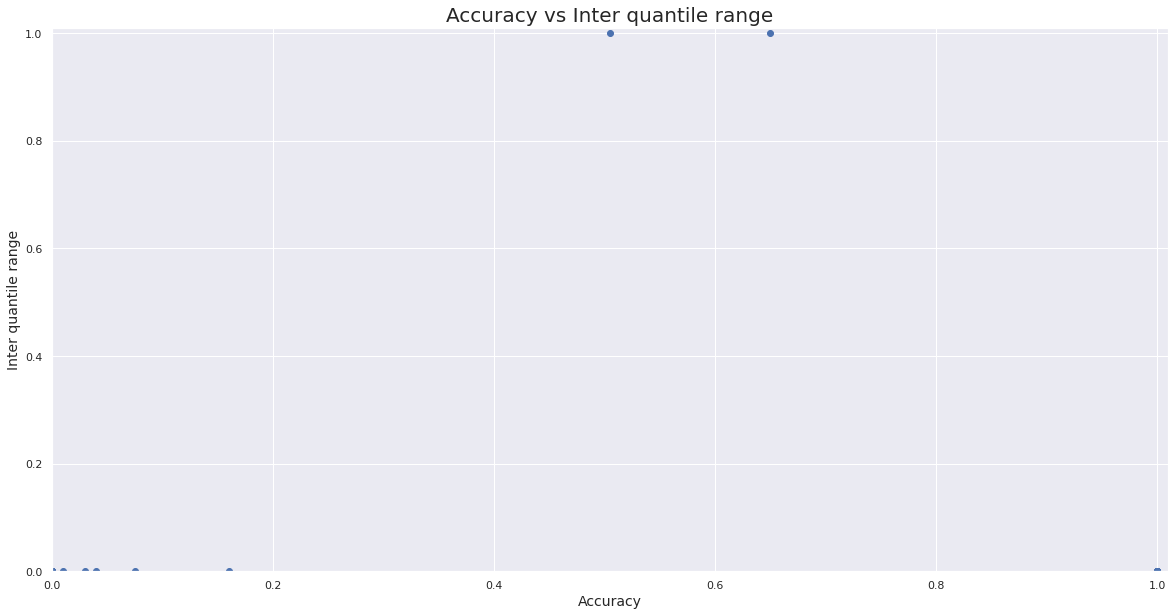

In [24]:
stability_analyzer.measure_stability_metrics(make_plots=True)